
# Week 5 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json
import os

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
I plan to analyze the People's Daily corpus to see how the Chinese government try to combine the contradictive concepts "socialist" and "market economy" together and convey the idea of socialist market economy to the public without eliciting widespread resistance. To be specific, what contexts had to remain constant to guard the redline in ideology - socialist, and what contexts had to be modified to contain  "market economy" in the existing construction of ideology. In addition, there is a time gap between Reform and Open and socialist market economy. From 1979 to 1992, Reform and Open changed the functioning of Chinese economy a lot, but it was not until 1993 that "market" was introduced to Chinese economy. It is interesting to investigate whether the concept of market was graduately introduced during these years, or was suddenly raised to deal with the shock to Chinese economy.

Cell 3:

## ***Why?***
On the one hand, socialist market economy is the most fundamental construction of Chinese economy, and it is also the most unique one all over the world, combining two contradictive concepts together. Therefore, understanding how socialist market economy comes into being is always of great value and importance. On the other hand, there is rich literature comparing the transformation of China and the Soviet, most of which investigating why China succeeded while the Soviet failed. Exploring how the idea socialist market economy is conveyed and accepted helps explain the success through the lens of exchange and trade in the economy. In addition, few researches utilize computational content analysis approach to investigate this question (with most of them focusing on mechanism design), so our project would provide new perspectives towards it.

Cell 4:

## ***How?***
First of all I plan to conduct a conting-words analysis to see whether the frequency of ideology and market related words are changing over time. This would throw light on whether "socialist market economy" forms gradually. After that, I would like to train a topic model to explore the topics of People's Daily over time. To be specific, what topics are more likely to discussed before 1975, from 1975 to 1992, and after 1992. Do the topics show a systematic change towards "market"? Then I may train a word2vec model and visualize it to see the similar words of ideology and market related words. A dynamic word2vec model could be employed to describe the time trend of ideology and market related words. 

Cell 5:

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
I plan to use People's Daily from 1949 to 2003 and divide it into three periods: pre-1975, 1975-1992, and post-1992. This division echoes the acceptance of market of the public. People's Daily is the main channel through which the Chinese government communicate with the public and transfer its thoughts and decisions, so the news articles in it are carefully scarved to fit the need of the Chinese government. In addition, in the late 20th century when the social media in China was highly concentrated, People's Daily had absolute advantages in terms of coverage and popularity. Hence, People's Daily could also reflects the mainstream of the Chinese public. A potential limitation would be early ending of our sample given that the ready-made data ends in 2003. Longer sample might be required to yield a more robust sample, so an alternative would be scraping the texts from the official website of People's Daily to prolong the sample. A reasonalbe path to "scale up" our sample is to include local dailies as well, especailly those representing local governments.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

In [13]:
print(newsgroupsTFVects.shape)

(2350, 1000)


The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [19]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,3
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data\20news_home\20news-b...,3
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0


We can also look at the distinguishing features in each cluster:

In [20]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 thanks
 know
 mac
 just
 does
 drive
 like
 apple
 don
 use


Cluster 1:
 window
 server
 motif
 use
 widget
 program
 using
 application
 code
 running


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 price
 interested
 10


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 dealer
 don
 new




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [21]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [22]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [23]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

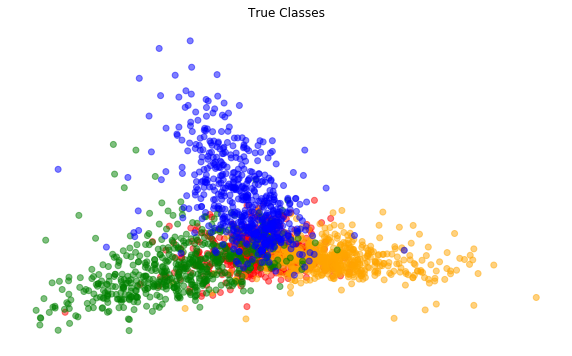

In [24]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

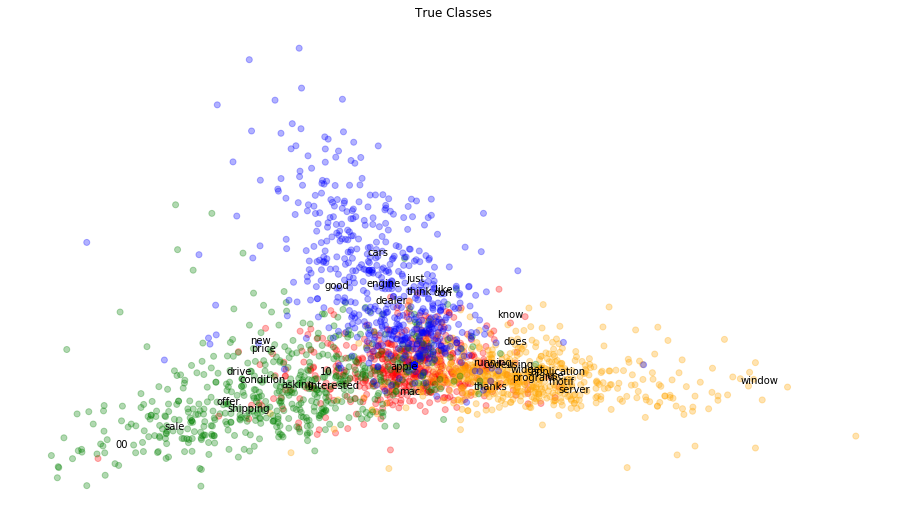

In [25]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [26]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

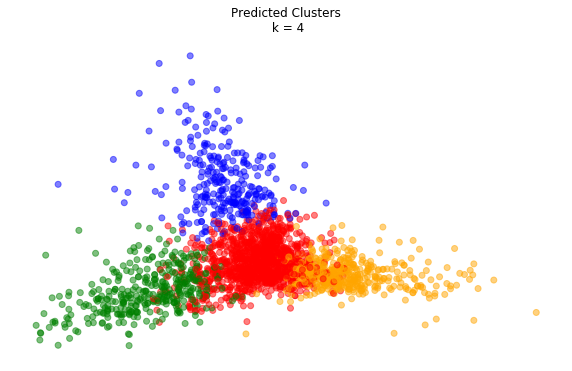

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [28]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [29]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


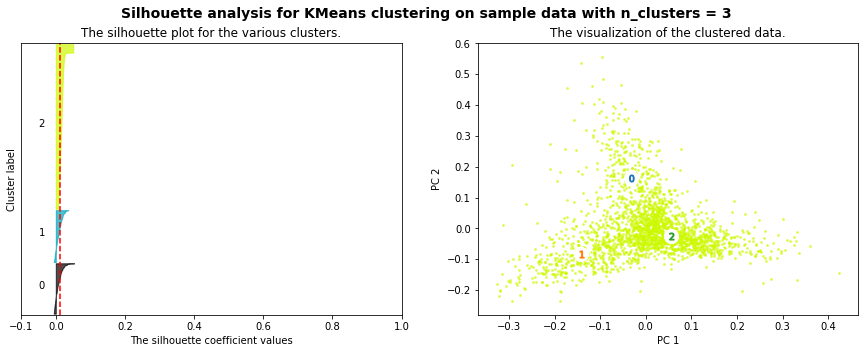

For n_clusters = 3, The average silhouette_score is : 0.013


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


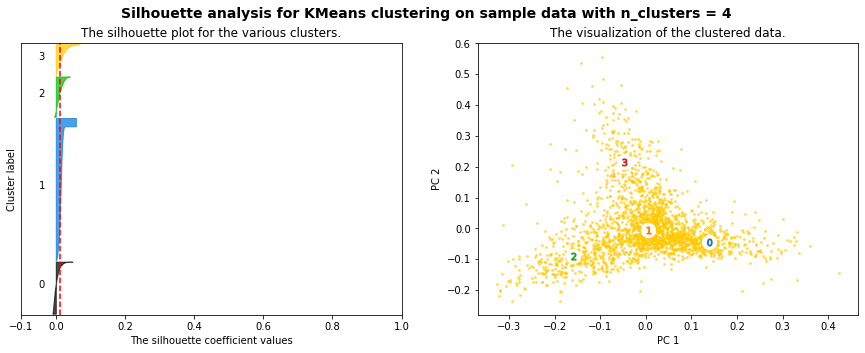

For n_clusters = 4, The average silhouette_score is : 0.012


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


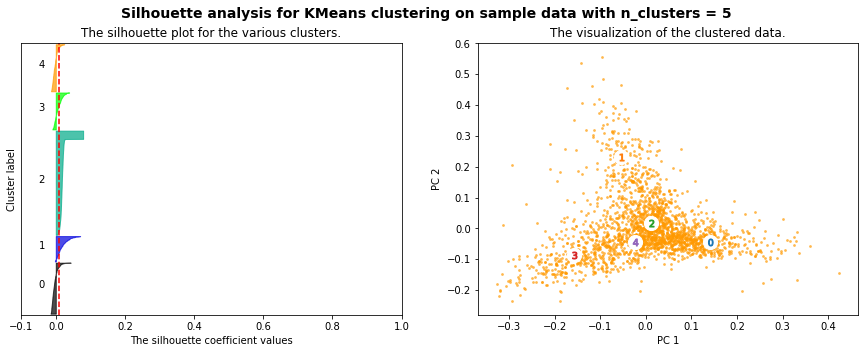

For n_clusters = 5, The average silhouette_score is : 0.010


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


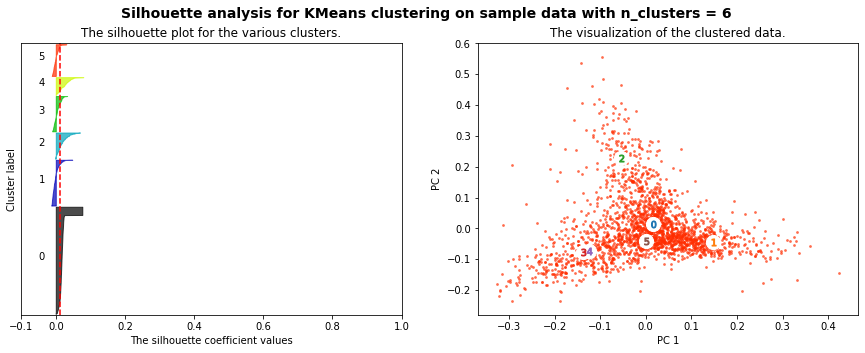

For n_clusters = 6, The average silhouette_score is : 0.011


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [34]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [35]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [36]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [37]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [38]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [39]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [40]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

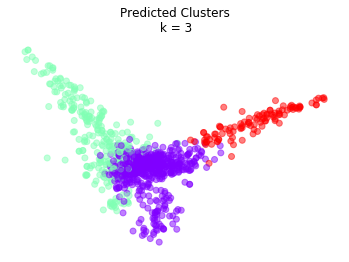

In [41]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [42]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,0
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

I use the FOMC Minutes from 2007 to 2016 to do the cluster analysis.

In [43]:
# Write a funtion to load the documents and convert them into a dataframe
def load_corpus_to_df(corpus_name, df):
    for file in os.listdir(corpus_name + '/'):
        Minutes_whole = []
        with open(corpus_name + '/' + file, encoding='utf8', errors='ignore') as f:
            for line in f:
                line_clean = line.replace('\n', '').replace('\t', ' ')
                if line_clean:
                    Minutes_whole.append(line_clean)
        df = df.append({'date': file[5:-4], 'text': ' '.join(Minutes_whole)}, ignore_index=True)
    return df

In [44]:
# Construct the dataframe for Minutes
Minutes_txt = r"FOMC_ZLB"

Minutes_df = pandas.DataFrame(columns = ["date", "text"])
Minutes_df = load_corpus_to_df(Minutes_txt, Minutes_df)

In [45]:
Minutes_df.head()

,date,text
0,20070131,"In the agenda for this meeting, it was reporte..."
1,20070321,The Manager of the System Open Market Account ...
2,20070509,The Manager of the System Open Market Account ...
3,20070628,The information reviewed at the June meeting s...
4,20070807,"In the agenda for this meeting, it was reporte..."


In [46]:
# Generate tf-idf matrix (I do not specify max_df because some economic jargons appear in every Minutes but they are important)
MinutesTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=500, min_df=3, stop_words='english', norm='l2')
MinutesTFVects = MinutesTFVectorizer.fit_transform(Minutes_df['text'])
MinutesTFVects.shape

(80, 500)

In [47]:
# Perform KMeans clustering with 2 clusters
num_cate = 2

MinutesKM = sklearn.cluster.KMeans(n_clusters = num_cate, init='k-means++', random_state=10)
MinutesKM.fit(MinutesTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

In [48]:
# Perform PCA to reduce dimensions and visualize in 2-D graphs
MinutesPCA = sklearn.decomposition.PCA(n_components = 2).fit(MinutesTFVects.toarray())
MinutesPCA_data = MinutesPCA.transform(MinutesTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, num_cate)))
colors_p = [colors[l] for l in MinutesKM.labels_]

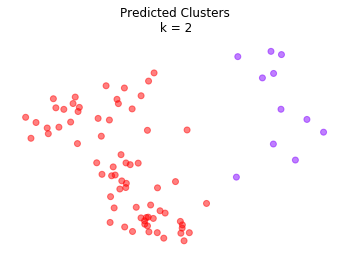

In [49]:
# Plot the clusters
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(MinutesPCA_data[:, 0], MinutesPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_cate))
plt.show()

In [50]:
# Investigate the two clusters
Minutes_df['kmeans_predictions'] = MinutesKM.labels_
Minutes_df[Minutes_df['kmeans_predictions'] == 0]

,date,text,kmeans_predictions
0,20070131,"In the agenda for this meeting, it was reporte...",0
8,20080130,"In the agenda for this meeting, it was reporte...",0
16,20090128,"In the agenda for this meeting, it was reporte...",0
24,20100127,Annual Organizational Matters In the agenda fo...,0
32,20110126,Annual Organizational Matters In the agenda fo...,0
40,20120125,Role of Financial Conditions in Economic Recov...,0
48,20130130,Annual Organizational Matters In the agenda fo...,0
56,20140129,Annual Organizational Matters In the agenda fo...,0
64,20150128,Annual Organizational Matters In the agenda fo...,0
72,20160127,Annual Organizational Matters In the agenda fo...,0


In [51]:
# Redefine the helper function to find the optimal number of clusters according to Silhouette method
def plotSilhouette_Minutes(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(MinutesPCA_data[:, 0], MinutesPCA_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Instantiate the new PCA
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(X)
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


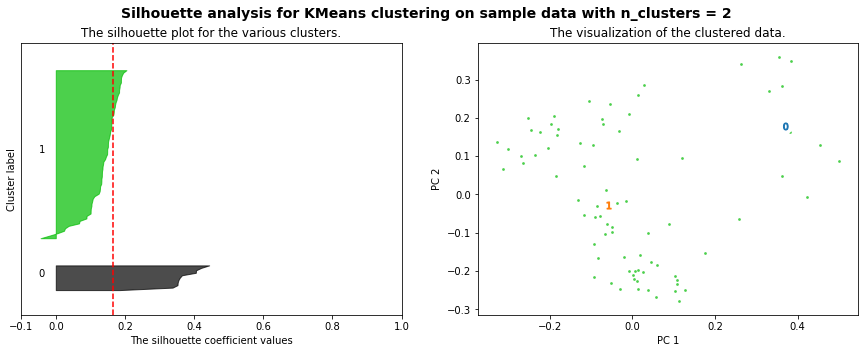

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 2, The average silhouette_score is : 0.165


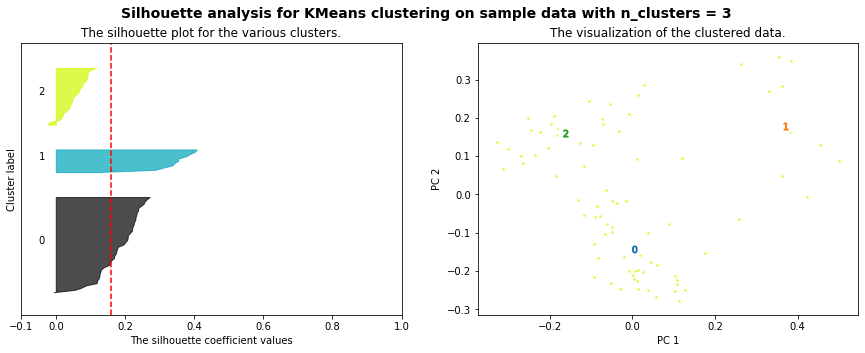

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.161


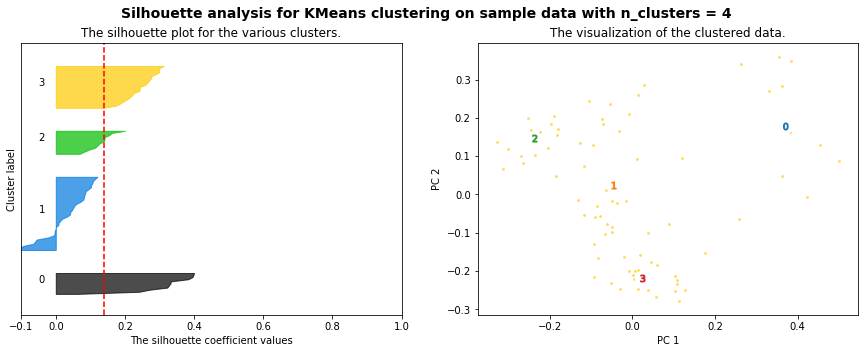

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 4, The average silhouette_score is : 0.140


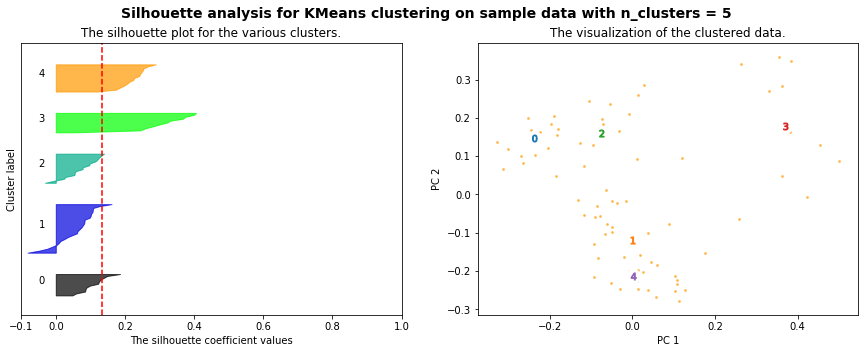

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 5, The average silhouette_score is : 0.133


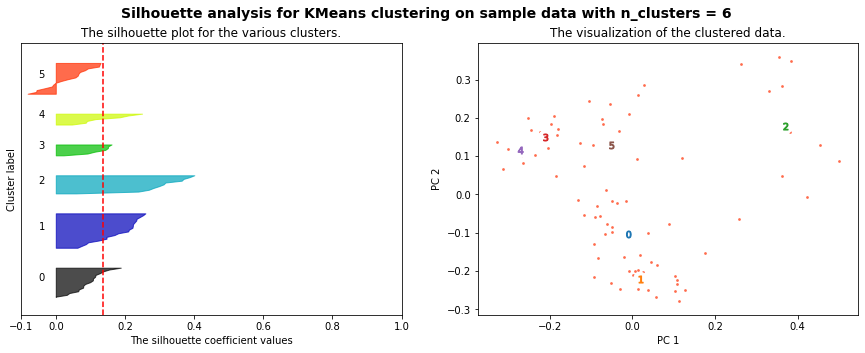

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 6, The average silhouette_score is : 0.137


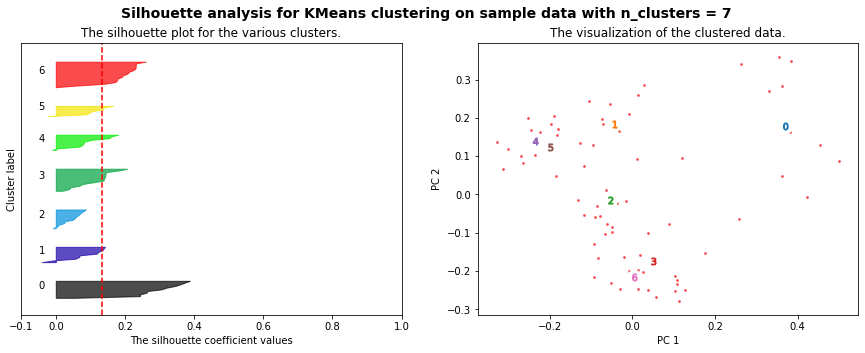

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 7, The average silhouette_score is : 0.133


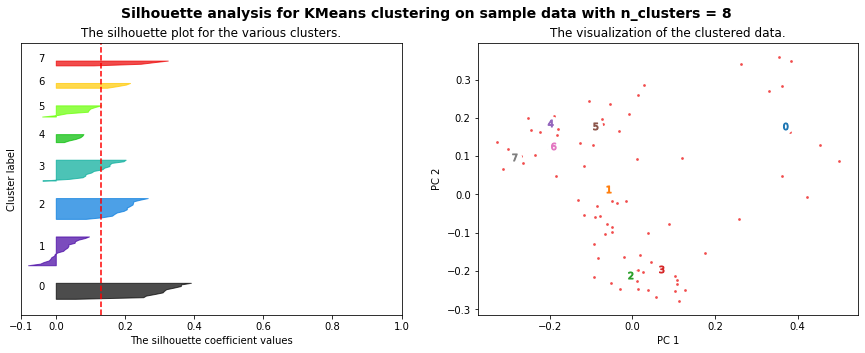

For n_clusters = 8, The average silhouette_score is : 0.131


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


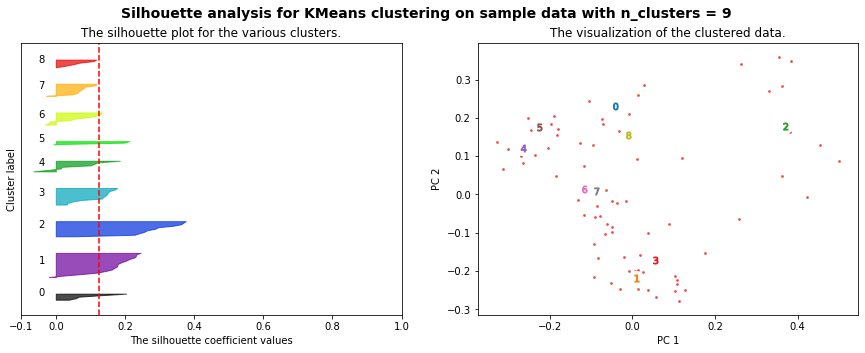

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 9, The average silhouette_score is : 0.126


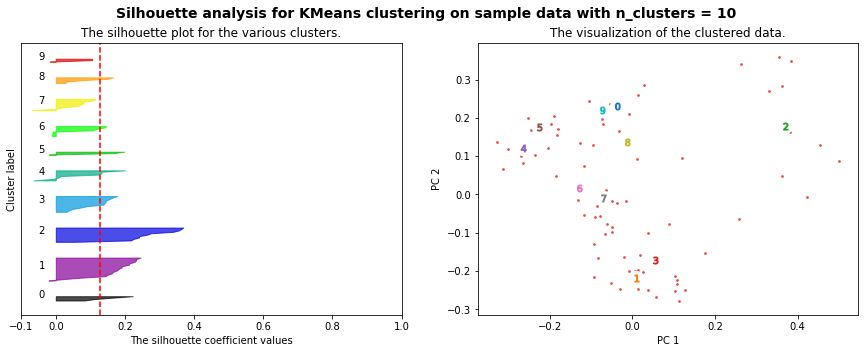

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 10, The average silhouette_score is : 0.127


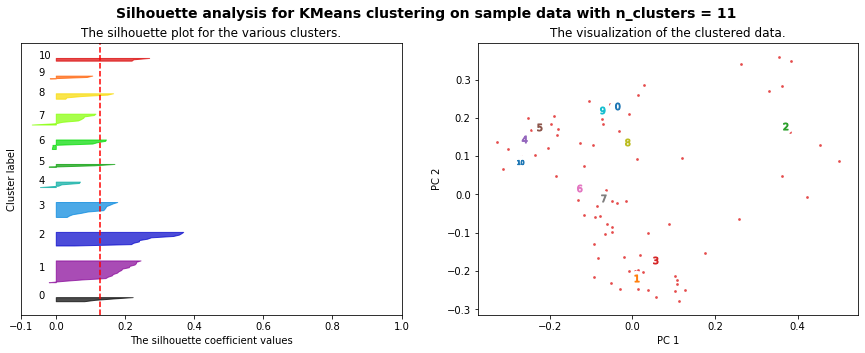

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 11, The average silhouette_score is : 0.129


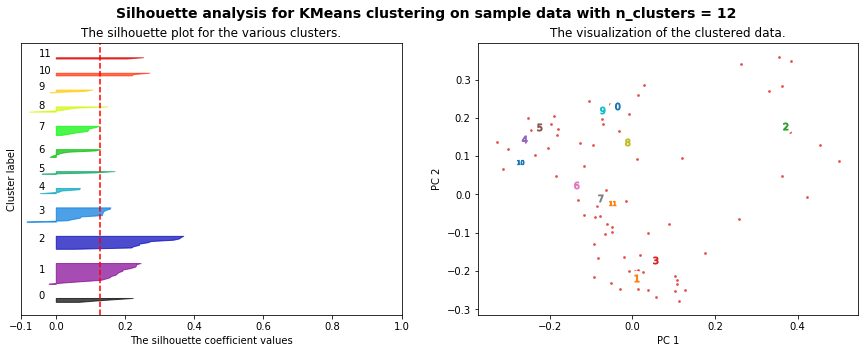

For n_clusters = 12, The average silhouette_score is : 0.127


In [52]:
# Identify the "optimal" cluster number
for num in range(2, 13):
    X = MinutesTFVects.toarray()
    plotSilhouette_Minutes(num, X)

### Summary
According to Silhouette method, it seems that the K-means clustering with two categories perform the best. Generally, when the number of clusters becomes larger, the performance becomes poorer. The K-means clustering put most Minutes for the meetings in January in one cluster. The reason is that these Minutes do not always touch into real economic issues for most of the times. Instead, they list the elected FOMC members of the coming year and the corresponding voting results; they also endow the Fed the rights of open market operations and foreign currency operations. Hence, the contents of these Minutes are quite different from others.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [53]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [54]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [55]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


C:\Users\Thinkpad\Anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [56]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [57]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [58]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

C:\Users\Thinkpad\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 76.        , 143.        ,   0.        ,   2.        ],
       [145.        , 200.        ,   0.        ,   3.        ],
       [148.        , 201.        ,   0.        ,   4.        ],
       [155.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 119.        ,   0.40914841,   2.        ],
       [160.        , 194.        ,   0.44134524,   2.        ],
       [112.        , 199.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [152.        , 196.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

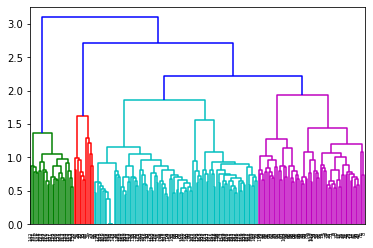

In [59]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

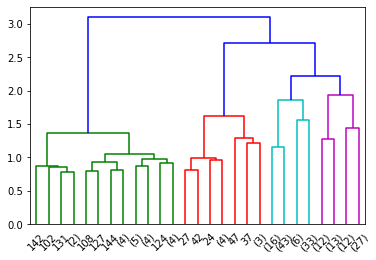

In [60]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [61]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [62]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [63]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,3,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data\20news_home\20news-b...,3,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [64]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

C:\Users\Thinkpad\Anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\Thinkpad\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

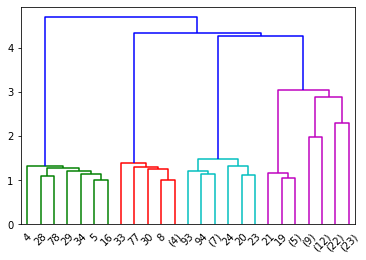

In [65]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [66]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

### Part 1: Measure distance by word occurence matrix

In [67]:
# Unconstrained method
MinutesCoocMat = MinutesTFVects * MinutesTFVects.T
MinutesCoocMat.setdiag(0)
Minuteslinkage_matrix = scipy.cluster.hierarchy.ward(MinutesCoocMat.toarray())

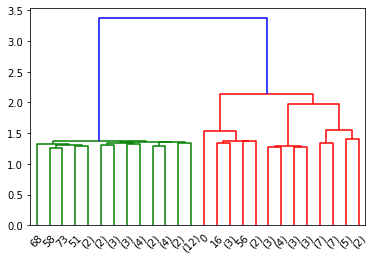

In [68]:
ax = scipy.cluster.hierarchy.dendrogram(Minuteslinkage_matrix, p=4, truncate_mode='level')

In [69]:
# K-means like method
MinuteshierarchicalClusters = scipy.cluster.hierarchy.fcluster(Minuteslinkage_matrix, 2, 'maxclust')
Minutes_df['wald_predictions'] = MinuteshierarchicalClusters

In [70]:
# Investigate the two clusters
Minutes_df[Minutes_df['wald_predictions'] == 2]

,date,text,kmeans_predictions,wald_predictions
0,20070131,"In the agenda for this meeting, it was reporte...",0,2
1,20070321,The Manager of the System Open Market Account ...,1,2
2,20070509,The Manager of the System Open Market Account ...,1,2
3,20070628,The information reviewed at the June meeting s...,1,2
4,20070807,"In the agenda for this meeting, it was reporte...",1,2
5,20070918,"In the agenda for this meeting, it was reporte...",1,2
6,20071031,"By unanimous vote, the Federal Open Market Com...",1,2
7,20071211,The Manager of the System Open Market Account ...,1,2
8,20080130,"In the agenda for this meeting, it was reporte...",0,2
9,20080318,The Manager of the System Open Market Account ...,1,2


In [71]:
# Compare with K-means according to Silhouette method
Kmeans_silhouette_avg = sklearn.metrics.silhouette_score(MinutesTFVects, MinutesKM.fit_predict(MinutesTFVects))
Wald_silhouette_avg = sklearn.metrics.silhouette_score(MinutesTFVects, MinuteshierarchicalClusters)

print("The average Silhouette score for K-means clustering is {:.3f}".format(Kmeans_silhouette_avg))
print("The average Silhouette score for Wald clustering is {:.3f}".format(Wald_silhouette_avg))

The average Silhouette score for K-means clustering is 0.165
The average Silhouette score for Wald clustering is 0.089


### Summary
It seems that Wald clustering put most Minutes before 2012 and in January into one category and put the others into another category. In addition, the Minutes before 2012 and in January seem to be more similar to each other. This may suggest that the topics covered in Minutes are becoming more spread since 2012. However, Wald clustering does worse than K-means clustering in terms of Silhouette score. The potential reason would be the Minutes in January are highly similar to each other.

### Part 2:  Measure distance by cosine similarity

In [72]:
# Unconstrained method
MinutesCosinMat = 1 - sklearn.metrics.pairwise.cosine_similarity(MinutesTFVects)
Minuteslinkage_matrix_cos = scipy.cluster.hierarchy.ward(MinutesCosinMat)

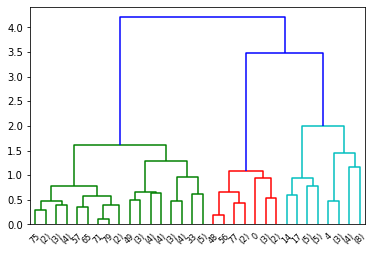

In [73]:
ax = scipy.cluster.hierarchy.dendrogram(Minuteslinkage_matrix_cos, p=4, truncate_mode='level')

In [74]:
# K-means like method
MinuteshierarchicalClusters_cos = scipy.cluster.hierarchy.fcluster(Minuteslinkage_matrix_cos, 2, 'maxclust')
Minutes_df['wald_predictions_cos'] = MinuteshierarchicalClusters_cos

In [75]:
# Investigate the two clusters
Minutes_df[Minutes_df['wald_predictions_cos'] == 2]

,date,text,kmeans_predictions,wald_predictions,wald_predictions_cos
0,20070131,"In the agenda for this meeting, it was reporte...",0,2,2
1,20070321,The Manager of the System Open Market Account ...,1,2,2
2,20070509,The Manager of the System Open Market Account ...,1,2,2
3,20070628,The information reviewed at the June meeting s...,1,2,2
4,20070807,"In the agenda for this meeting, it was reporte...",1,2,2
5,20070918,"In the agenda for this meeting, it was reporte...",1,2,2
6,20071031,"By unanimous vote, the Federal Open Market Com...",1,2,2
7,20071211,The Manager of the System Open Market Account ...,1,2,2
8,20080130,"In the agenda for this meeting, it was reporte...",0,2,2
9,20080318,The Manager of the System Open Market Account ...,1,2,2


In [76]:
# Calculate Silhouette score
Wald_silhouette_avg_cos = sklearn.metrics.silhouette_score(MinutesTFVects, MinuteshierarchicalClusters_cos)
Wald_silhouette_avg_cos

0.1123840330743402

### Summary
The results from cosine similarity are similar to those from word occurrence matrix except that more Minutes after 2012 are separated from those before 2012. According to Silhouette score, using coine similarity to measure distance does better than using word occurrence matrix. 

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [77]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [78]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [79]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [80]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [81]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [82]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [83]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [84]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(0, 0.97378075)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [85]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [86]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(3, 0.9713957)]",0.000000,0.000000,0.000000,0.971396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(7, 0.18039109), (8, 0.8079708)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180391,0.807971,0.000000
201,04May2006Kennedy8.txt,"[(2, 0.09631833), (3, 0.88442194), (6, 0.01741...",0.000000,0.000000,0.096318,0.884422,0.000000,0.000000,0.017412,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(1, 0.046725735), (5, 0.15635248), (6, 0.2153...",0.000000,0.046726,0.000000,0.000000,0.000000,0.156352,0.215332,0.580212,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(2, 0.11581862), (4, 0.4794652), (8, 0.399541...",0.000000,0.000000,0.115819,0.000000,0.479465,0.000000,0.000000,0.000000,0.399541,0.000000
501,09Nov2005Kennedy11.txt,"[(2, 0.9556274)]",0.000000,0.000000,0.955627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(0, 0.97246474)]",0.972465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.7806724), (9, 0.2167276)]",0.780672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216728
801,15Dec2005Kennedy5.txt,"[(2, 0.99821925)]",0.000000,0.000000,0.998219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(5, 0.9539718)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.953972,0.000000,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [87]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.973781,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.971396,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.0,0.992996,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.105882,0.476036,0.0,0.159526,0.0,0.254548,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.0,0.031676,0.0,0.000000,0.000000,0.966249,0.0,0.0
5,0.000000,0.000000,0.0,0.446673,0.0,0.000000,0.000000,0.545602,0.0,0.0
6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.989593,0.0,0.0
7,0.676652,0.000000,0.0,0.000000,0.0,0.000000,0.294838,0.000000,0.0,0.0
8,0.000000,0.000000,0.0,0.995039,0.0,0.000000,0.000000,0.000000,0.0,0.0
9,0.000000,0.000000,0.0,0.967241,0.0,0.000000,0.000000,0.000000,0.0,0.0


First we can visualize as a stacked bar chart:

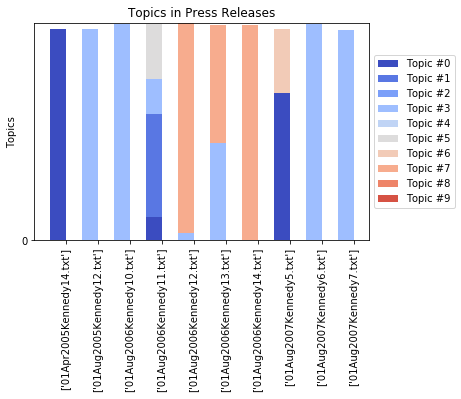

In [88]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

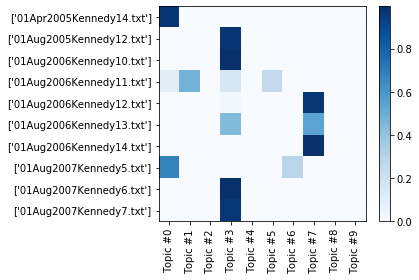

In [89]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [90]:
senlda.show_topic(1)

[('worker', 0.014706089),
 ('wage', 0.0054112556),
 ('attorney', 0.0049619777),
 ('unite', 0.0039569833),
 ('rule', 0.003739554),
 ('judge', 0.0035981152),
 ('fund', 0.0034272312),
 ('woman', 0.0032918877),
 ('minimum', 0.0032594844),
 ('troop', 0.0032586535)]

And if we want to make a dataFrame:

In [91]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,worker,fund,loan,worker,fund,immigration,wage,troop,worker
1,loan,wage,mental,lender,minimum,asbestos,worker,minimum,fund,pension
2,head,attorney,company,worker,head,worker,fund,worker,worker,fund
3,company,unite,head,company,wage,loan,coverage,judge,mental,unite
4,unite,rule,worker,rate,fund,insurance,unite,hour,concern,retirement
5,worker,judge,tax,cell,company,troop,citizen,intelligence,unite,immigrant
6,leader,fund,science,wage,loan,victim,insurance,follow,send,head
7,fda,woman,standard,fund,follow,teacher,border,fund,hear,immigration
8,agency,minimum,medicare,stem,woman,trust,company,unite,fail,city
9,victim,troop,aid,aid,bankruptcy,standard,loan,employer,rule,woman


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

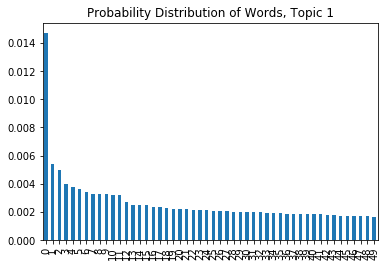

In [92]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [93]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

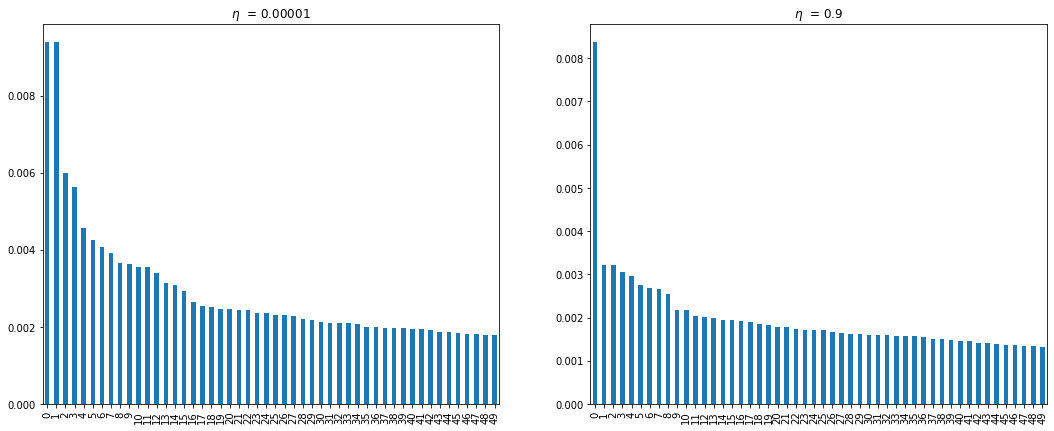

In [94]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [95]:
# Tokenize and normalize the text
Minutes_df['tokenized_text'] = Minutes_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
Minutes_df['normalized_tokens'] = Minutes_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [96]:
# Drop missings
Minutes_df['reduced_tokens'] = Minutes_df['normalized_tokens'].apply(lambda x: dropMissing(x, MinutesTFVectorizer.vocabulary_.keys()))

In [97]:
# Construct the dictionary
Minutesdictionary = gensim.corpora.Dictionary(Minutes_df['reduced_tokens'])

In [98]:
# Construct the corpus
Minutescorpus = [Minutesdictionary.doc2bow(text) for text in Minutes_df['reduced_tokens']]

gensim.corpora.MmCorpus.serialize('Minutes.mm', Minutescorpus)
Minutesmm = gensim.corpora.MmCorpus('Minutes.mm')

In [99]:
# Run the LDA model
MinutesLDA = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=10, alpha='auto', eta='auto')

In [100]:
# Examine Minutes 9 
Minutes9Bow = Minutesdictionary.doc2bow(Minutes_df['reduced_tokens'][9])
Minutes9LDA = MinutesLDA[Minutes9Bow]
print("The topics of the Minutes on {}/{}/{}".format(Minutes_df['date'][9][4:6], Minutes_df['date'][9][6:], Minutes_df['date'][9][:4]))
print("are: {}".format(Minutes9LDA))

The topics of the Minutes on 03/18/2008
are: [(0, 0.15068527), (1, 0.027904177), (2, 0.046254706), (3, 0.018270336), (4, 0.064739525), (5, 0.37567982), (6, 0.049736906), (7, 0.07138233), (8, 0.08260315), (9, 0.11274375)]


In [101]:
# Create a dataframe for topics of each Minutes
MinutesldaDF = pandas.DataFrame({'date' : Minutes_df['date'],
                                 'topics' : [MinutesLDA[Minutesdictionary.doc2bow(l)] for l in Minutes_df['reduced_tokens']]})

MinutesldaDF.head()

,date,topics
0,20070131,"[(0, 0.017268214), (1, 0.044691913), (3, 0.107..."
1,20070321,"[(0, 0.09314467), (1, 0.04487647), (2, 0.04783..."
2,20070509,"[(0, 0.07819562), (1, 0.025574619), (2, 0.0461..."
3,20070628,"[(0, 0.07420672), (1, 0.029720547), (2, 0.0277..."
4,20070807,"[(0, 0.040332757), (1, 0.03447048), (2, 0.0579..."


In [102]:
# Construct the probability table
# Dict to temporally hold the probabilities
MinutestopicsProbDict = {i : [0] * len(MinutesldaDF) for i in range(MinutesLDA.num_topics)}

# Load them into the dict
for index, topicTuples in enumerate(MinutesldaDF['topics']):
    for topicNum, prob in topicTuples:
        MinutestopicsProbDict[topicNum][index] = prob

# Update the DataFrame
for topicNum in range(MinutesLDA.num_topics):
    MinutesldaDF['topic_{}'.format(topicNum)] = MinutestopicsProbDict[topicNum]

In [103]:
# Visualize the 16 Minutes from 2011 to 2012
MinutesldaDFV = MinutesldaDF[32:48][['topic_%d' %x for x in range(10)]]
MinutesldaDFVisN = MinutesldaDF[32:48][['date']]
MinutesldaDFVis = MinutesldaDFV.values
MinutesldaDFVisNames = MinutesldaDFVisN.values
MinutesldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
32,0.026395,0.064767,0.042027,0.079452,0.075520,0.044556,0.501007,0.091487,0.051336,0.023453
33,0.148781,0.099966,0.077955,0.013345,0.128562,0.133771,0.051402,0.117155,0.111637,0.117426
34,0.061959,0.097927,0.181192,0.022816,0.125836,0.171311,0.066791,0.120199,0.093477,0.058492
35,0.092231,0.049224,0.117825,0.028762,0.089286,0.158777,0.063830,0.131983,0.172935,0.095147
36,0.070607,0.040841,0.111229,0.061282,0.152649,0.148566,0.041788,0.069603,0.237284,0.066150
37,0.029555,0.043391,0.169208,0.092172,0.087593,0.118263,0.073123,0.070686,0.254709,0.061300
38,0.088273,0.077913,0.111771,0.080076,0.071776,0.126897,0.071009,0.094349,0.221813,0.056124
39,0.070719,0.093326,0.074474,0.080036,0.071377,0.107235,0.218721,0.101315,0.136039,0.046758
40,0.015530,0.106138,0.022783,0.097923,0.079538,0.047682,0.455284,0.096667,0.062595,0.015860
41,0.092648,0.157691,0.054625,0.038085,0.084662,0.105645,0.064597,0.157523,0.144252,0.100272


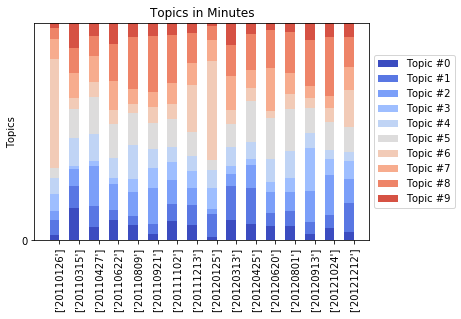

In [104]:
# Bar chart
N = 16
K = MinutesLDA.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, MinutesldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, MinutesldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += MinutesldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Minutes')
plt.xticks(ind+width/2, MinutesldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

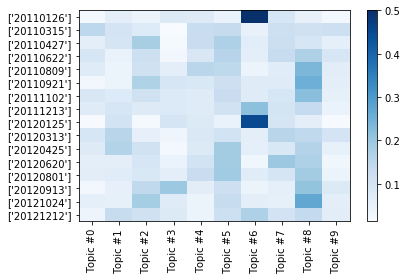

In [105]:
# Heatmap
plt.pcolor(MinutesldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(MinutesldaDFVis.shape[0])+0.5, MinutesldaDFVisNames);
plt.xticks(np.arange(MinutesldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [106]:
# Show the top words from each topic to get a sense of the semantic (or syntactic) domain they represent
MinutestopicsDict = {}
for topicNum in range(MinutesLDA.num_topics):
    topicWords = [w for w, p in MinutesLDA.show_topic(topicNum)]
    MinutestopicsDict['Topic_{}'.format(topicNum)] = topicWords

MinuteswordRanksDF = pandas.DataFrame(MinutestopicsDict)
MinuteswordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,price,committee,rate,federal,committee,market,rate,inflation,market,committee
1,inflation,rate,market,committee,rate,inflation,committee,committee,rate,market
2,market,market,committee,participant,market,committee,market,market,committee,price
3,participant,economic,economic,market,increase,rate,participant,rate,economic,rate
4,rate,price,price,price,economic,economic,continue,economic,price,inflation
5,committee,inflation,inflation,rate,inflation,participant,inflation,policy,inflation,economic
6,economic,policy,increase,inflation,participant,federal,price,remain,policy,policy
7,continue,participant,participant,economic,federal,price,bank,federal,remain,participant
8,increase,continue,policy,financial,price,continue,federal,term,participant,increase
9,remain,federal,term,increase,continue,policy,increase,increase,continue,remain


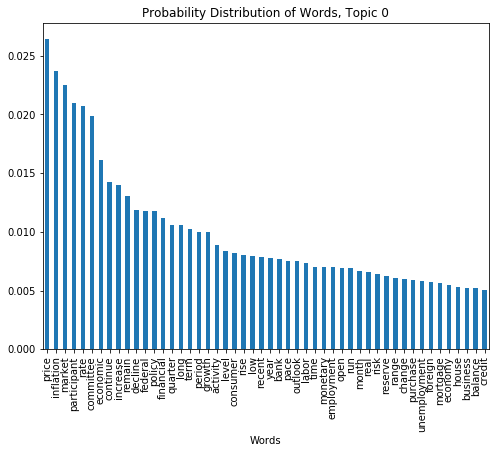

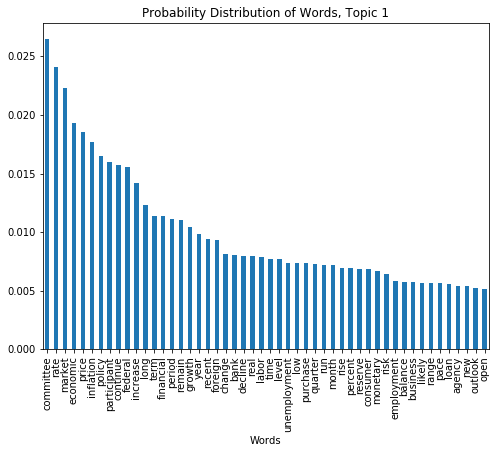

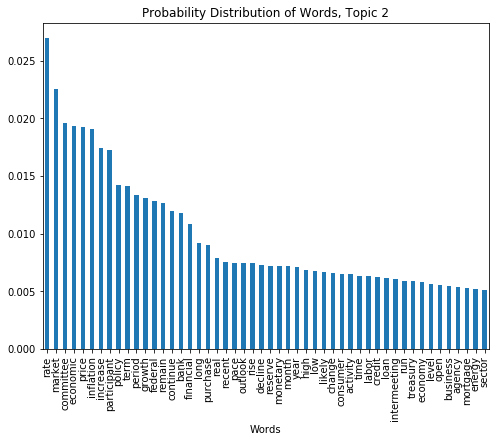

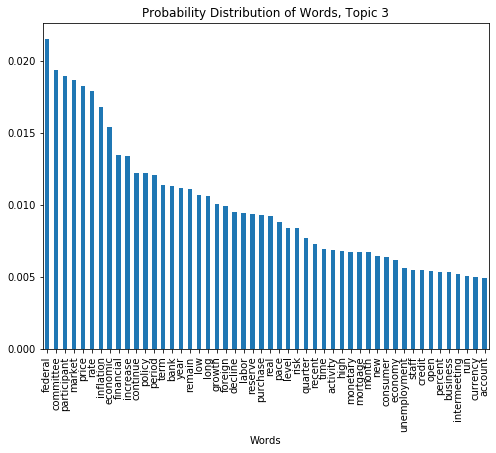

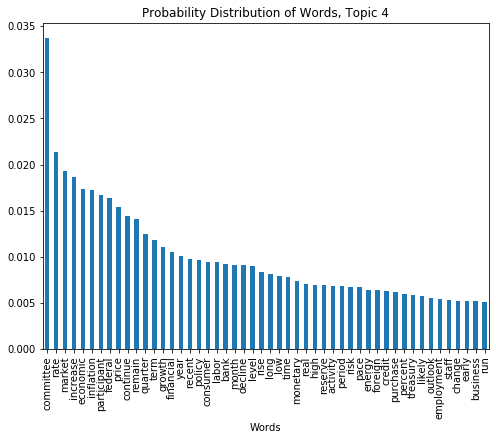

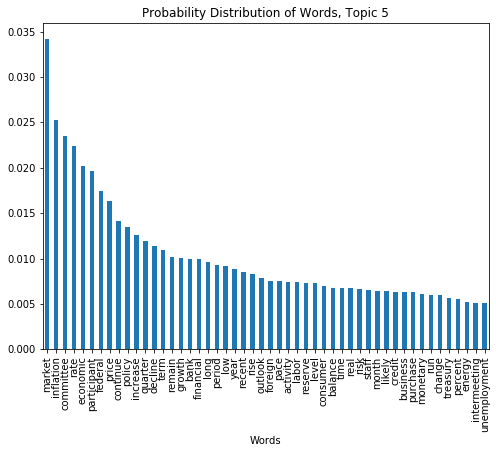

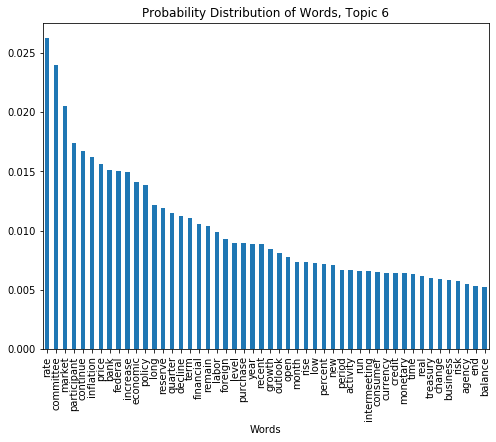

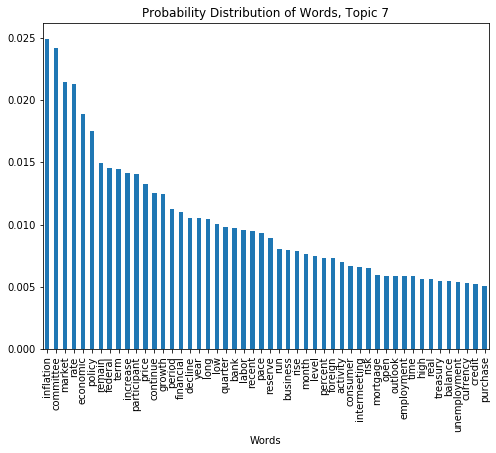

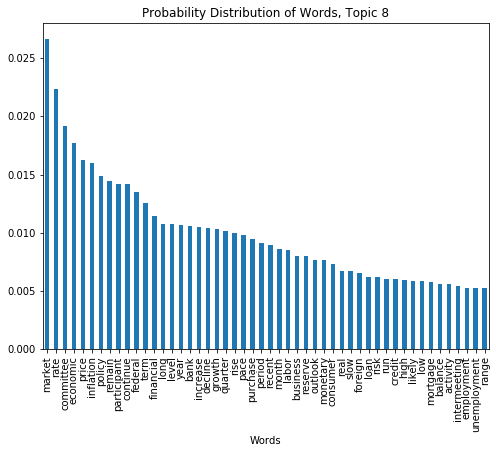

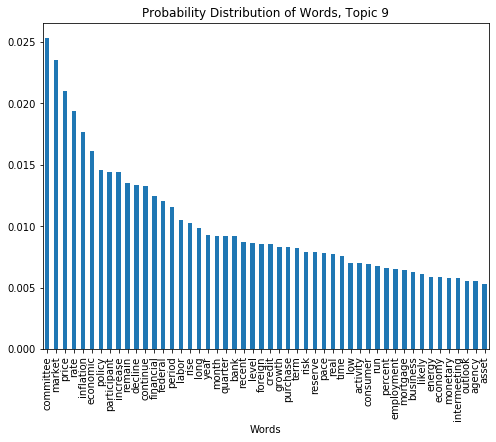

In [107]:
# Probability distribution of words for each topic
for topicNum in range(MinutesLDA.num_topics):
    Minutestopic_df = pandas.DataFrame(MinutesLDA.show_topic(topicNum, topn=50))
    Minutestopic_df.set_index([0], inplace=True)
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    Minutestopic_df.plot.bar(legend = False, ax=ax)
    plt.title(f'Probability Distribution of Words, Topic {topicNum}')
    plt.xlabel(r'Words')
    plt.show()

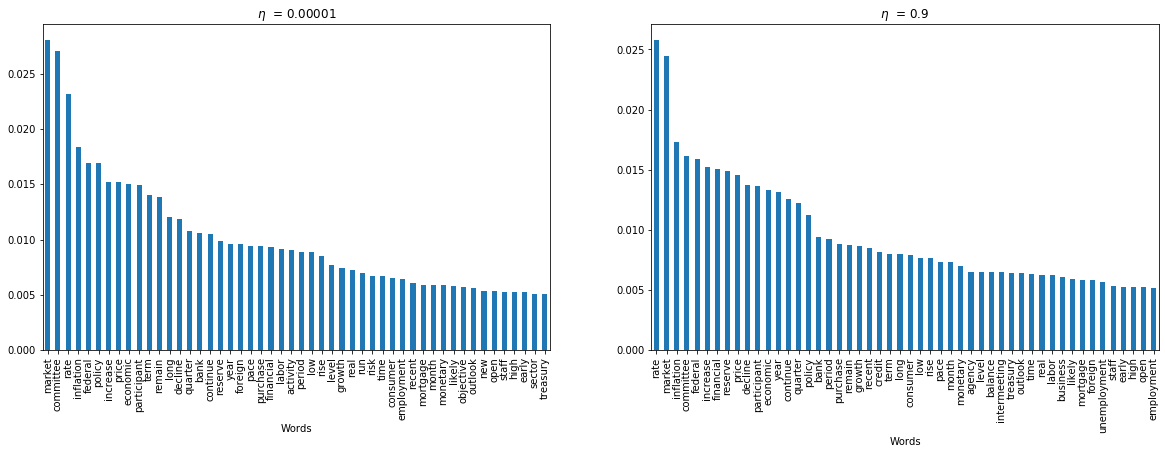

In [108]:
# Tune eta for topic 1
MinutesLDA_etaS = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=10, eta = 0.00001)
MintuesLDA_etaL = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=10, eta = 0.9)

Minutestopic1_etaS_df = pandas.DataFrame(MinutesLDA_etaS.show_topic(1, topn=50))
Minutestopic1_etaL_df = pandas.DataFrame(MintuesLDA_etaL.show_topic(1, topn=50))
Minutestopic1_etaS_df.set_index([0], inplace=True)
Minutestopic1_etaL_df.set_index([0], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
Minutestopic1_etaS_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
Minutestopic1_etaL_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
ax1.set_xlabel('Words')
ax2.set_xlabel('Words')
plt.show()

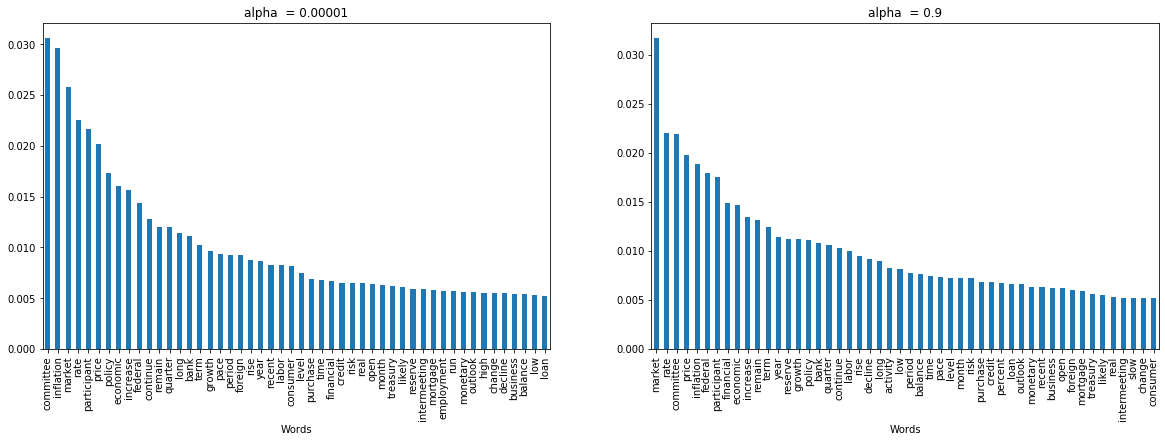

In [109]:
# Tune alpha for topic 1
MinutesLDA_alpS = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=10, alpha = 0.00001)
MintuesLDA_alpL = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=10, alpha = 0.9)

Minutestopic1_alpS_df = pandas.DataFrame(MinutesLDA_alpS.show_topic(1, topn=50))
Minutestopic1_alpL_df = pandas.DataFrame(MintuesLDA_alpL.show_topic(1, topn=50))
Minutestopic1_alpS_df.set_index([0], inplace=True)
Minutestopic1_alpL_df.set_index([0], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
Minutestopic1_alpS_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.00001')
Minutestopic1_alpL_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
ax1.set_xlabel('Words')
ax2.set_xlabel('Words')
plt.show()

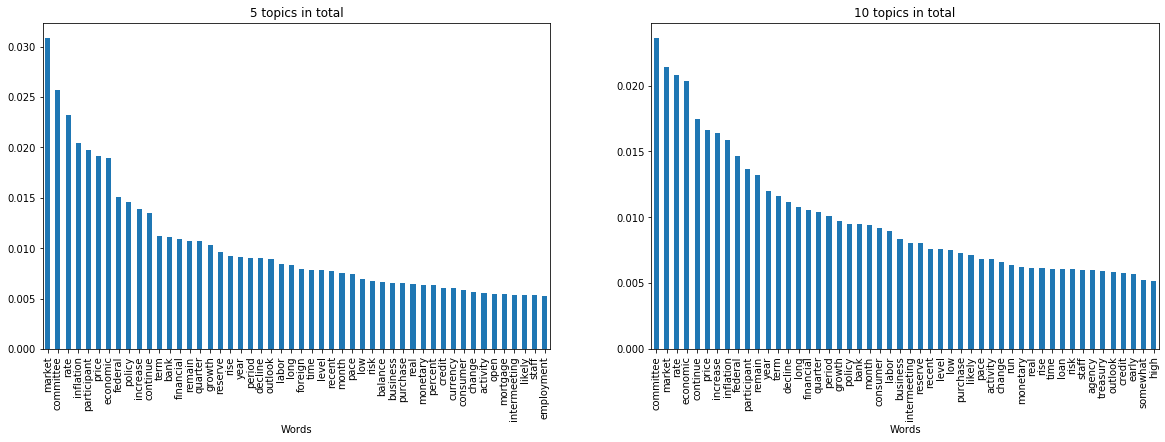

In [110]:
# Tune topic numbers for topic 1
MinutesLDA_numS = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=5, alpha = 0.01, eta = 0.01)
MintuesLDA_numL = gensim.models.ldamodel.LdaModel(corpus=Minutesmm, id2word=Minutesdictionary, num_topics=10, alpha = 0.01, eta = 0.01)

Minutestopic1_numS_df = pandas.DataFrame(MinutesLDA_numS.show_topic(1, topn=50))
Minutestopic1_numL_df = pandas.DataFrame(MintuesLDA_numL.show_topic(1, topn=50))
Minutestopic1_numS_df.set_index([0], inplace=True)
Minutestopic1_numL_df.set_index([0], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
Minutestopic1_numS_df.plot.bar(legend = False, ax = ax1, title = '5 topics in total')
Minutestopic1_numL_df.plot.bar(legend = False, ax = ax2, title = '10 topics in total')
ax1.set_xlabel('Words')
ax2.set_xlabel('Words')
plt.show()

### Summary
From the above analyses we can see that most Minutes cover all the topics, which is not surprising because the range of topics of each FOMC meeting are to some extent fixed. However, different Minutes may place different weights to different topics, which should be determined by current economic situation.   

Smaller $\eta$ and larger $\alpha$ place more probability on the top words, so the distributions are less smoother. Tuning the topic numbers totally changes the word distribution in each topic, so the results are hard to be compared.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [111]:
corpora_address = "../week-4/SOAP"

In [112]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


In [113]:
import zipfile
import pandas as pd

In [114]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [115]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [116]:
soap_dict = {}

In [117]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [118]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [119]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [120]:
i = 0

In [121]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [122]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [123]:
dool = soap_df['Tokenized Texts'][9]

In [124]:
' '.join(dool[0:1500])

"@!Sharon Yeah I could n't sleep @!Victoria Nightmares @!Sharon Vicki thank you for spending the night @!Victoria Of course I would n't leave you and the kids alone You want to talk about it @!Sharon I do n't think I can @!Victoria It might help to get it out @!Sharon You know the worst part is n't when Matt Clark attacked me It was when he made me stare into his eyes He had this old picture of the way he used to look And I kept going from the picture to his face And then it was like like a horror movie or something I could n't breathe I felt like I was back in that car again @!Victoria Sharon there is nothing I can do or say to take the pain away I want you to know they will find him and you will never ever have to worry about Matt Clark ever again @!Nikki Hi You all right @!Victoria Any word on Matt Clark @!Nikki No they have him The police have helicopters They have search dogs @!Victor Apparently he left by car @!Sharon What car @!Victor Another set of tire marks were found near th

In [125]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [126]:
import networkx as nx

In [127]:
actor_network = nx.Graph()

In [128]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [129]:
i = 0

In [130]:
all_texts = []

In [131]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

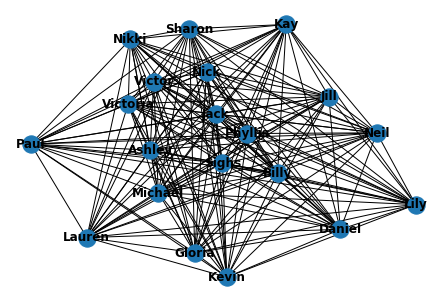

In [132]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [133]:
all_texts[0:10]

[['yes', 'sleep'],
 ['nightmare'],
 ['vicki', 'thank', 'spend', 'night'],
 ['course', 'leave', 'kid', 'want', 'talk'],
 ['think'],
 ['help'],
 ['know',
  'wrong',
  'matt',
  'clark',
  'attack',
  'stare',
  'eye',
  'old',
  'picture',
  'way',
  'look',
  'keep',
  'go',
  'picture',
  'face',
  'like',
  'like',
  'horror',
  'movie',
  'breathe',
  'feel',
  'like',
  'car'],
 ['sharon', 'pain', 'away', 'want', 'know', 'find', 'worry', 'matt', 'clark'],
 ['hello', 'right'],
 ['word', 'matt', 'clark']]

In [134]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [135]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [136]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [137]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [138]:
doollda.show_topics()

[(0,
  '0.096*"um" + 0.083*"thank" + 0.028*"baby" + 0.028*"know" + 0.027*"understand" + 0.025*"dad" + 0.024*"lose" + 0.021*"hold" + 0.016*"have" + 0.016*"sharon"'),
 (1,
  '0.103*"gon" + 0.102*"na" + 0.072*"know" + 0.047*"be" + 0.032*"go" + 0.019*"right" + 0.017*"phone" + 0.016*"help" + 0.016*"find" + 0.016*"think"'),
 (2,
  '0.140*"uh" + 0.039*"little" + 0.038*"try" + 0.027*"billy" + 0.024*"ricky" + 0.024*"long" + 0.022*"huh" + 0.020*"know" + 0.020*"be" + 0.019*"guess"'),
 (3,
  '0.159*"be" + 0.089*"right" + 0.071*"hey" + 0.042*"mm" + 0.039*"sure" + 0.036*"sorry" + 0.035*"hmm" + 0.022*"victor" + 0.017*"bring" + 0.016*"leave"'),
 (4,
  '0.117*"want" + 0.065*"good" + 0.053*"think" + 0.040*"say" + 0.034*"know" + 0.030*"adam" + 0.024*"away" + 0.020*"care" + 0.019*"see" + 0.018*"kid"'),
 (5,
  '0.087*"come" + 0.063*"like" + 0.057*"get" + 0.056*"look" + 0.032*"let" + 0.028*"know" + 0.021*"home" + 0.019*"fine" + 0.018*"door" + 0.018*"right"'),
 (6,
  '0.172*"okay" + 0.092*"mean" + 0.051*"hel

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [139]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [140]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Sharon [(0, 0.15244837), (1, 0.12623098), (4, 0.15535983), (5, 0.062786065), (6, 0.14605124), (8, 0.24458839), (9, 0.11253212)]
Victoria [(0, 0.15335512), (1, 0.12443992), (4, 0.15720892), (5, 0.06499415), (6, 0.14701116), (8, 0.24416386), (9, 0.108822644)]
Nikki [(0, 0.1553298), (1, 0.122031026), (4, 0.16047315), (5, 0.06263398), (6, 0.14643805), (8, 0.24566689), (9, 0.10742367)]
Victor [(0, 0.15083665), (1, 0.12391573), (4, 0.16171168), (5, 0.06290957), (6, 0.14545532), (8, 0.24546023), (9, 0.109708145)]
Billy [(0, 0.15580325), (1, 0.11963869), (4, 0.15672147), (5, 0.06141211), (6, 0.14620535), (8, 0.24518079), (9, 0.1150322)]
Phyllis [(0, 0.15471981), (1, 0.12857485), (4, 0.15332507), (5, 0.059772145), (6, 0.14265856), (8, 0.24721716), (9, 0.11372981)]
Jack [(0, 0.15087852), (1, 0.12191051), (4, 0.15863372), (5, 0.066251785), (6, 0.14233072), (8, 0.2524627), (9, 0.10752952)]
Paul [(0, 0.15070112), (1, 0.120747894), (4, 0.15787257), (5, 0.06602625), (6, 0.14523792), (8, 0.25141972), 

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [141]:
from gensim.matutils import kullback_leibler

In [142]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [143]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

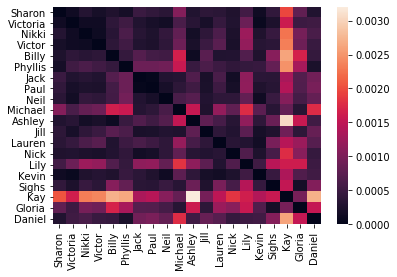

In [144]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [145]:
corpora_address = "COHA"

In [146]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


In [147]:
list(coha_texts.keys())[0:5]

['mag_1815_552651.txt',
 'mag_1816_552727.txt',
 'mag_1816_552728.txt',
 'mag_1816_552807.txt',
 'mag_1816_552808.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [148]:
coha_genres = {}
coha_years = {}

In [149]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [150]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [151]:
coha_years.keys()

dict_keys(['1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [152]:
import collections

In [153]:
years = []
year_lens = []

In [154]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [155]:
years[0], years[-1]

('1810', '2009')

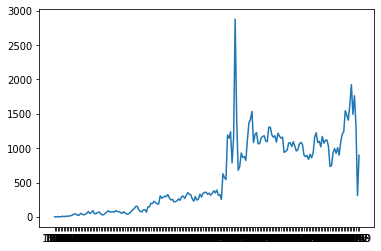

In [156]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [157]:
all_texts_coha = []
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

For this exercise I will continue to use the Soap datasets and investigate the topics in Port Charles, which is an extention of the homework of last week. (Last week I finally decided to analyze the networks in Port Charles, but I forgot to correct the description in Exercise 4 and the variable name in the code.)

In [159]:
pc = soap_df['Tokenized Texts'][8]

In [160]:
# Extract all the characters
characters_pc = {}

for token in pc:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters_pc:
            characters_pc[token[2:]] = 0
        if token[2:] in characters_pc:
            characters_pc[token[2:]] += 1
            
len(characters_pc)

226

In [161]:
# Delete characters with low number of appearances
for character in characters_pc:
    if characters_pc[character] > 300:
        print(character, characters_pc[character])

Jack 913
Kevin 952
Eve 487
Ian 1046
Lucy 1317
Livvie 940
Karen 418
Frank 306
Alison 1372
Jamal 854
Caleb 397
Rafe 822


In [162]:
# Create a network graph
actor_network_pc = nx.Graph()

for character in characters_pc:
    if characters_pc[character] > 300:
        actor_network_pc.add_node(character, lines_spoken=characters_pc[character], words=[])

In [163]:
i = 0
all_texts_pc = []

for token in pc:
    i += 1
    if i > len(pc):
        break
    if token[0] == "@":
        if token[2:] in actor_network_pc.nodes():
            j = i
            for token_ in pc[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network_pc.nodes():
                        if (token[2:], token_[2:]) not in actor_network_pc.edges():
                            actor_network_pc.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network_pc.edges():
                            actor_network_pc.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network_pc.nodes[token[2:]]['words'].append(pc[i:j])
            all_texts_pc.append(lucem_illud_2020.normalizeTokens(pc[i:j]))

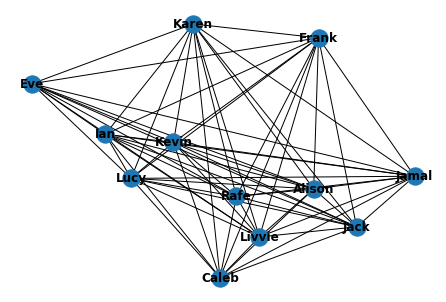

In [164]:
# Visualize the network
nx.draw(actor_network_pc, with_labels=True, font_weight='bold')

In [165]:
# Create a dictionary
pc_dictionary = gensim.corpora.Dictionary(all_texts_pc)

In [166]:
# Construct the corpus
pc_corpus = [pc_dictionary.doc2bow(text) for text in all_texts_pc]

gensim.corpora.MmCorpus.serialize('pc.mm', pc_corpus)
pc_mm = gensim.corpora.MmCorpus('pc.mm')

In [173]:
# Run the LDA model
pcLDA = gensim.models.ldamodel.LdaModel(corpus=pc_mm, id2word=pc_dictionary, num_topics=10, alpha='auto', eta='auto')

In [174]:
# Show the topics
pcLDA.show_topics()

[(0,
  '0.061*"caleb" + 0.047*"get" + 0.035*"know" + 0.030*"look" + 0.024*"have" + 0.020*"kill" + 0.018*"kind" + 0.015*"wrong" + 0.014*"night" + 0.013*"mean"'),
 (1,
  '0.135*"think" + 0.047*"good" + 0.034*"alison" + 0.029*"yes" + 0.025*"lucy" + 0.025*"hmm" + 0.021*"know" + 0.017*"idea" + 0.015*"little" + 0.015*"vampire"'),
 (2,
  '0.066*"love" + 0.045*"livvie" + 0.032*"know" + 0.031*"ian" + 0.024*"jack" + 0.022*"go" + 0.022*"oh" + 0.021*"god" + 0.017*"jamal" + 0.015*"alison"'),
 (3,
  '0.079*"want" + 0.053*"like" + 0.048*"feel" + 0.044*"know" + 0.034*"talk" + 0.033*"have" + 0.017*"fight" + 0.016*"tell" + 0.016*"right" + 0.014*"give"'),
 (4,
  '0.091*"okay" + 0.084*"go" + 0.060*"be" + 0.039*"know" + 0.032*"wait" + 0.022*"help" + 0.018*"think" + 0.017*"have" + 0.016*"try" + 0.015*"right"'),
 (5,
  '0.128*"right" + 0.056*"come" + 0.042*"mean" + 0.034*"stop" + 0.034*"okay" + 0.030*"know" + 0.022*"sure" + 0.017*"rafe" + 0.017*"friend" + 0.016*"stay"'),
 (6,
  '0.117*"be" + 0.086*"oh" + 0.0

In [175]:
# Examine the topics by actor
for actor in actor_network_pc.nodes():
    actor_all_words_pc = []
    for sent in actor_network_pc.nodes[actor]['words']:
        for word in sent:
            actor_all_words_pc += word
    actor_network_pc.nodes[actor]['topic_distribution'] = pcLDA[pc_dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words_pc))]

In [176]:
for actor in actor_network_pc.nodes():
    print(actor_network_pc.nodes[actor]['topic_distribution'])

[(0, 0.20366228), (5, 0.094237946), (6, 0.14618422), (7, 0.29985714), (9, 0.25603735)]
[(0, 0.18612126), (5, 0.10027321), (6, 0.15149508), (7, 0.31064945), (9, 0.25144178)]
[(0, 0.20231764), (5, 0.09513081), (6, 0.16175711), (7, 0.30085903), (9, 0.23989792)]
[(0, 0.19177394), (5, 0.095877536), (6, 0.15867984), (7, 0.30256456), (9, 0.25108314)]
[(0, 0.20725669), (5, 0.097941026), (6, 0.14973634), (7, 0.29820827), (9, 0.24684761)]
[(0, 0.20553206), (5, 0.09086383), (6, 0.15780719), (7, 0.3036856), (9, 0.2420918)]
[(0, 0.19724546), (5, 0.098310664), (6, 0.15635477), (7, 0.30661362), (9, 0.24142495)]
[(0, 0.18771796), (5, 0.09272494), (6, 0.164958), (7, 0.3044036), (9, 0.2501384)]
[(0, 0.21169432), (5, 0.09283148), (6, 0.15191464), (7, 0.2944002), (9, 0.24914606)]
[(0, 0.20679127), (5, 0.09422103), (6, 0.14686854), (7, 0.2871478), (9, 0.26494858)]
[(0, 0.20273109), (5, 0.09250066), (6, 0.14447515), (7, 0.30767214), (9, 0.2525745)]
[(0, 0.19696592), (5, 0.09553001), (6, 0.14601888), (7, 0.3

In [177]:
# Examine the similarity between actors
L_pc = []
for actor_1 in actor_network_pc.nodes():
    p = actor_network_pc.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network_pc.nodes():
        q = actor_network_pc.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L_pc.append(l)
M_pc = np.array(L_pc)

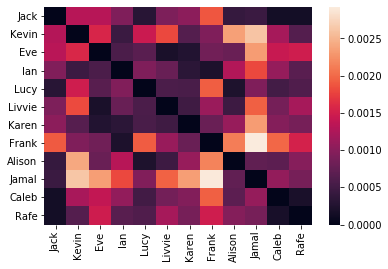

In [178]:
fig = plt.figure()
div = pandas.DataFrame(M_pc, columns = list(actor_network_pc.nodes()), index = list(actor_network_pc.nodes()))
ax = sns.heatmap(div)
plt.show()

### Summary
It seems that the LDA model could be better tuned because all the characters seems to have a similar probability distribution over the topics. However, from this imperfect model we could also see that Karen and Frank are similar to each other, while Kevin, Eve, Ian, and Lucy are similar to each other. This verifies the results from last week.